# Stability API - Initial Image Inference w/ Image Masking

**In this notebook we're going to go over how to use our API to perform an inference call with an initial image and an image mask that affects our final result.**

**Furthermore, we'll show you how to mask out a portion of your image to affect a specific portion of the result.**

In [1]:
#@title <a name="Step 1"><font color="#FFFFFF">1. Install the Stability SDK package.</font></a>

%pip install stability-sdk

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
#@title <a name="Step 2"><font color="#FFFFFF">2. Set up our environment variables and API Key.</font></a>

import getpass, os

# Our host url should not be prepended with "https" nor should it have a trailing slash.
os.environ['STABILITY_HOST'] = 'grpc.stability.ai:443'

# Sign up for an account at the following link to get an API Key.
# https://platform.stability.ai/

# Click on the following link once you have created an account to be taken to your API Key.
# https://platform.stability.ai/account/keys

# Paste your API Key below after running this cell.

os.environ['STABILITY_KEY'] = getpass.getpass('Enter your API Key')

In [3]:
#@title <a name="Step 3"><font color="#FFFFFF">3. Import additional dependencies and establish our connection to the API.</font></a>

import io
import os
import warnings

from IPython.display import display
from PIL import Image
from stability_sdk import client
from torchvision.transforms import GaussianBlur
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation


# Set up our connection to the API.
stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'], # API Key reference.
    verbose=True, # Print debug messages.
    engine="stable-diffusion-xl-1024-v1-0", # Set the engine to use for generation.
    # Check out the following link for a list of available engines: https://platform.stability.ai/docs/features/api-parameters#engine
)

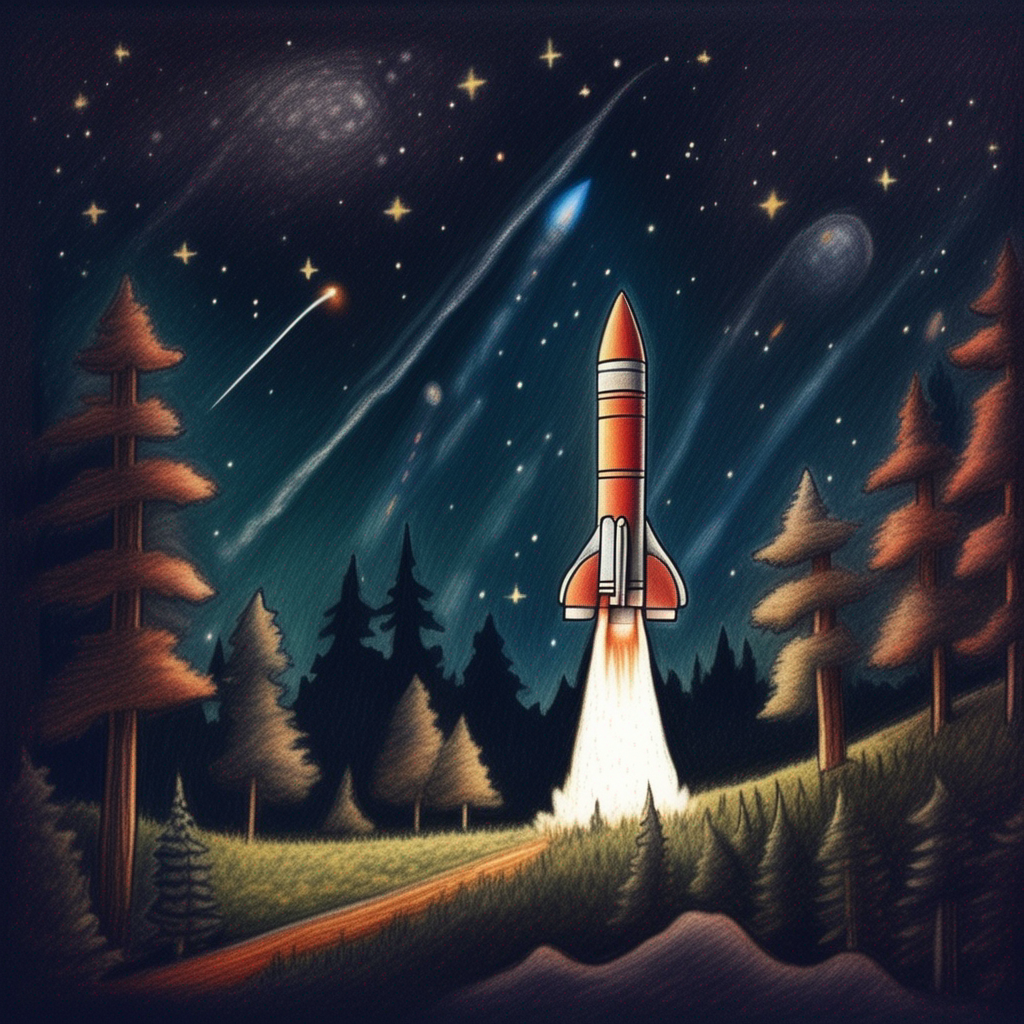

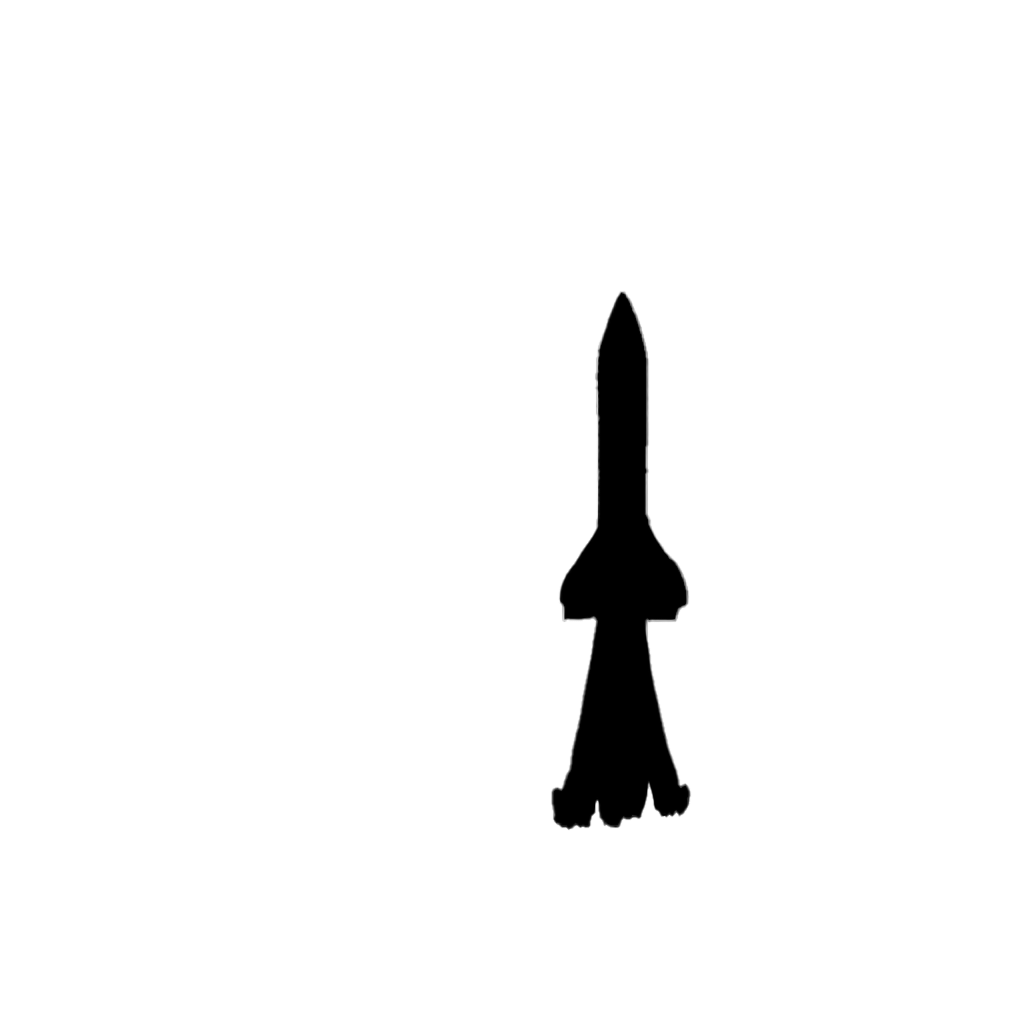

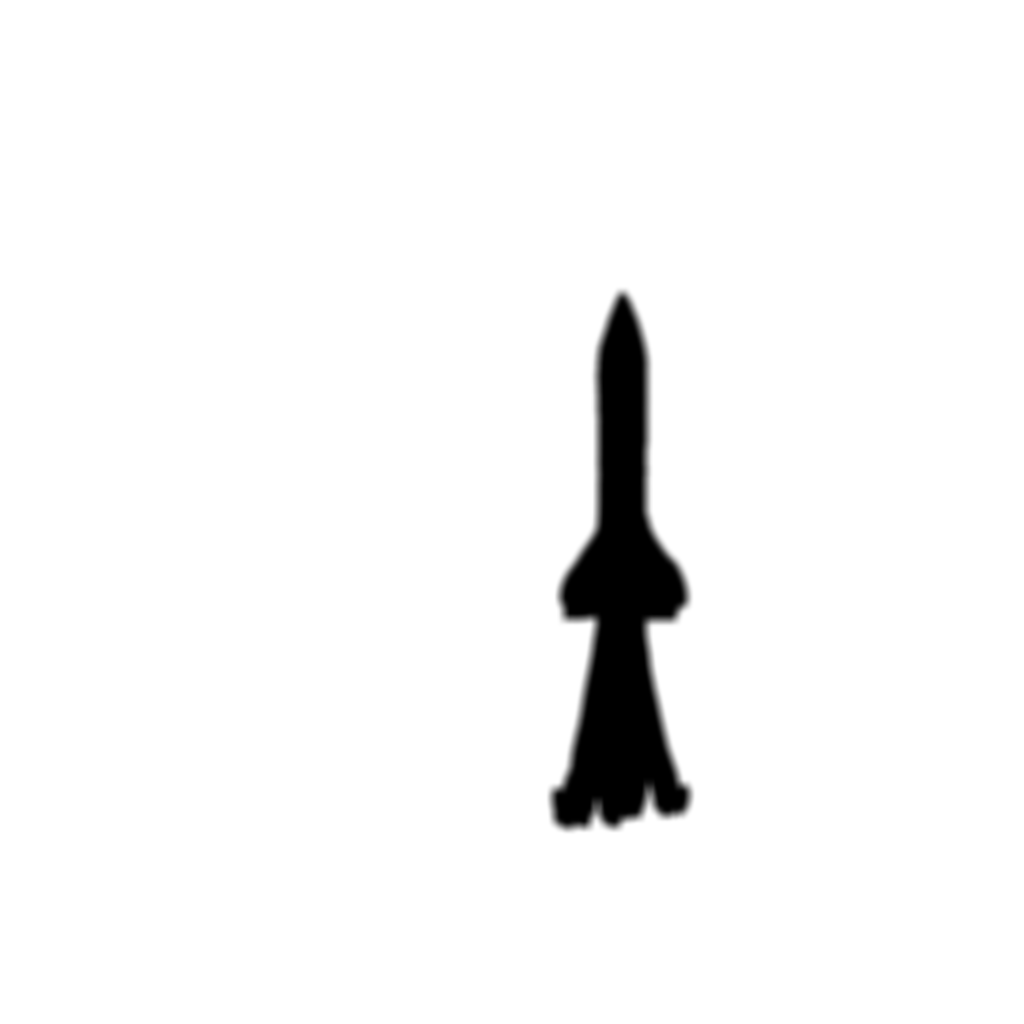

In [4]:
#@title <a name="Step 4"><font color="#FFFFFF">4. Import the image we want to work with and a mask to inform which areas of the image we want affected by the diffusion process.</font></a>

img = Image.open('./org_img.png')
display(img)

mask_i = Image.open('./mask_img.png')
display(mask_i)

# Feathering the edges of our mask generally helps provide a better result. Alternately, you can feather the mask in a suite like Photoshop or GIMP.

blur = GaussianBlur(11,20)
mask = blur(mask_i)
mask

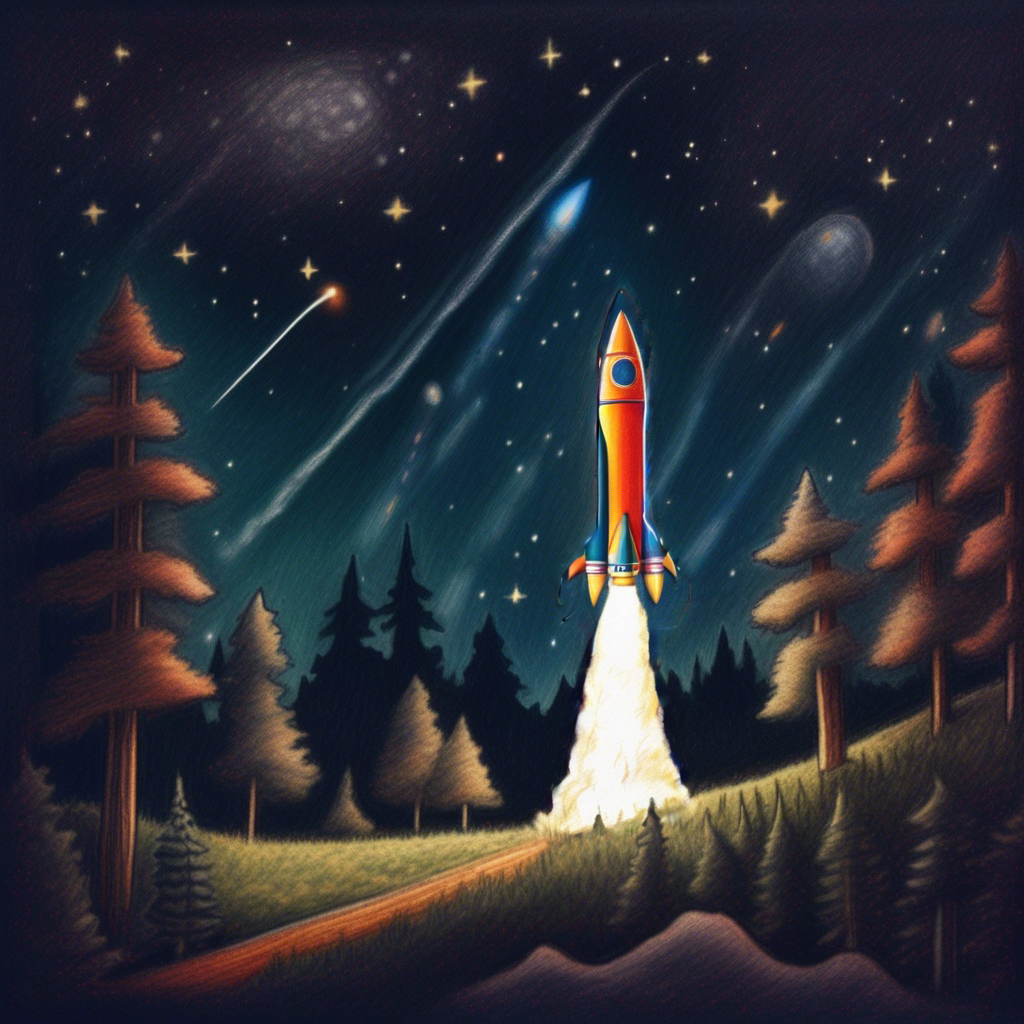

In [5]:
#@title <a name="Step 5"><font color="#FFFFFF">5. Now we can generate a new image, including our mask to affect the specific areas laid out above.</font></a>

answers = stability_api.generate(
    prompt="crayon drawing of rocket ship launching from forest",
    init_image=img,
    mask_image=mask,
    start_schedule=1,
    seed=44332211, # If attempting to transform an image that was previously generated with our API,
                   # initial images benefit from having their own distinct seed rather than using the seed of the original image generation.
    steps=50, # Amount of inference steps performed on image generation. Defaults to 30.
    cfg_scale=8.0, # Influences how strongly your generation is guided to match your prompt.
                   # Setting this value higher increases the strength in which it tries to match your prompt.
                   # Defaults to 7.0 if not specified.
    width=1024, # Generation width, if not included defaults to 512 or 1024 depending on the engine.
    height=1024, # Generation height, if not included defaults to 512 or 1024 depending on the engine.
    sampler=generation.SAMPLER_K_DPMPP_2M # Choose which sampler we want to denoise our generation with.
                                                 # Defaults to k_lms if not specified. Clip Guidance only supports ancestral samplers.
                                                 # (Available Samplers: ddim, plms, k_euler, k_euler_ancestral, k_heun, k_dpm_2, k_dpm_2_ancestral, k_dpmpp_2s_ancestral, k_lms, k_dpmpp_2m, k_dpmpp_sde)
)

# Set up our warning to print to the console if the adult content classifier is tripped. If adult content classifier is not tripped, display generated image.
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img2 = Image.open(io.BytesIO(artifact.binary))
            display(img2)